# 1次元の混合正規分布に対してのEMアルゴリズムを実装・描画
- https://cartman0.hatenablog.com/entry/2019/07/01/EM%E3%82%A2%E3%83%AB%E3%82%B4%E3%83%AA%E3%82%BA%E3%83%A0%E3%81%A7%E6%B7%B7%E5%90%88%E6%AD%A3%E8%A6%8F%E5%88%86%E5%B8%83%28MoG%29%E3%81%AE%E3%83%91%E3%83%A9%E3%83%A1%E3%83%BC%E3%82%BF%E3%82%92%E5%B0%8E
-  https://qiita.com/ta-ka/items/3e8b127620ac92a32864

In [1]:
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import warnings
import japanize_matplotlib

%matplotlib inline
warnings.simplefilter('ignore')

/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/japanize_matplotlib/__init__.py:13: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [2]:
# E-step
def EStep(k_size, data_x, lambda_vec, mu_vec, sigma2_vec):
    '''
    data_x[i]
    lambda[k]
    mu[k]
    sigma[k]
    '''
    I = len(data_x)
    # 中身を初期化せずに配列を作成する関数である。
    # 2行, 1000列の配列を生成
    responsibility = sp.empty((k_size, I))
    
    for k in sp.arange(k_size):
        norm = stats.norm(loc=mu_vec[k], scale=sp.sqrt(sigma2_vec[k]))
        #responsibility[k] =  norm.pdf(data_x)
        responsibility[k] = lambda_vec[k] * norm.pdf(data_x)

    responsibility = responsibility / sp.sum(responsibility, axis=0)
    return responsibility

def MStep(k_size, responsibility, data_x):

    lambda_vec = sp.empty(k_size)
    mu_vec = sp.empty(k_size)
    sigma2_vec = sp.empty(k_size)

    for k in sp.arange(k_size):
        r_k = responsibility[k]
        #lambda_vec[k] = sp.sum(r_k) / sp.sum(responsibility)
        lambda_vec[k] = sp.sum(r_k) / responsibility.shape[1]
        #mu_vec[k] = sp.sum(r_k * data_x) / sp.sum(r_k)
        mu_vec[k] = sp.sum(r_k * data_x) / sp.sum(r_k)
        sigma2_vec[k] = sp.sum(r_k * (data_x - mu_vec[k])**2) / sp.sum(r_k)

    return lambda_vec, mu_vec, sigma2_vec

In [3]:
def calc_mix_pdf(k_size, x, lambda_vec, mu_vec, sigma2_vec):
    pdf = sp.zeros_like(x)

    for k in sp.arange(k_size):
        norm_k = stats.norm(loc=mu_vec[k], scale=sp.sqrt(sigma2_vec[k]))
        
        # pdf (Probability density function) 確率密度関数
        # xのときの値を取得
        pdf += lambda_vec[k] * norm_k.pdf(x)
    return pdf

# データの生成  
- f1：平均20, 分散30, データ数15      
- f2：平均90, 分散100, データ数125    
- f1とf2の割合は15:135  
  
- Covid-19初期感染と似ているデータを想定

In [4]:
# 乱数seedの固定
np.random.seed(seed=123)

N1 = stats.norm(loc=30, scale=sp.sqrt(5))
N2 = stats.norm(loc=60, scale=sp.sqrt(2.5))
N3 = stats.norm(loc=72, scale=sp.sqrt(10))

# rvs (Random variates) 確率変数
s1 = N1.rvs(size=15)
s2 = N2.rvs(size=15)
s3 = N3.rvs(size=105)

# データの連結
data_x = sp.hstack((s1, s2, s3))
data_x

array([27.57245617, 32.23013222, 30.63275916, 26.63182263, 28.7062105 ,
       33.69272436, 24.57378025, 29.04092221, 32.83071953, 28.06190954,
       28.48196442, 29.78822431, 33.33484858, 28.5713717 , 29.00722616,
       59.31323033, 63.48788171, 63.4576124 , 61.58754861, 60.61061431,
       61.16588209, 62.35705429, 58.52031673, 61.85914896, 58.01744059,
       58.99162634, 61.43425925, 57.74105747, 59.77853191, 58.63744587,
       71.19166058, 63.15008419, 66.39792044, 69.78679386, 74.93289373,
       71.45091576, 72.00899958, 74.1763513 , 69.21866187, 72.89690835,
       69.45320745, 66.53662935, 70.76386631, 73.81453346, 73.07071259,
       71.96258869, 79.56532324, 73.3057429 , 75.09503501, 79.07763068,
       67.90774289, 68.71506325, 77.51410222, 69.47630404, 72.09386662,
       75.381474  , 74.81666092, 77.54943737, 76.72964204, 75.38171655,
       69.5564805 , 74.51357646, 72.99381531, 67.80598036, 76.48189311,
       74.55270606, 72.14385227, 71.26289818, 68.21063906, 72.63

(array([0.01331243, 0.00665622, 0.        , 0.        , 0.        ,
        0.00133124, 0.01996865, 0.02795611, 0.07854335, 0.03194984]),
 array([24.57378025, 30.13805807, 35.70233589, 41.26661372, 46.83089154,
        52.39516936, 57.95944718, 63.523725  , 69.08800282, 74.65228064,
        80.21655846]),
 <a list of 10 Patch objects>)

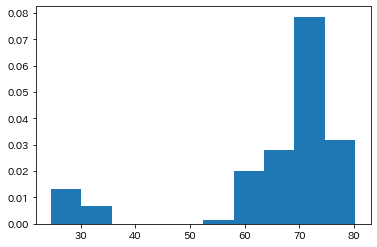

In [5]:
plt.hist(data_x, density=True)

## 初期値の設定  
- データをランダムに2分割  
- それぞれの平均値を初期値に用いる
- 分散は全体の標本分散を用いる  
  
## 参考
- 入門　パターン認識と機械学習(https://www.coronasha.co.jp/np/isbn/9784339024791/)


In [161]:
# データをランダムに2分割
random_x = np.split(data_x, 3)
random_x0 = random_x[0]
random_x1 = random_x[1]
random_x2 = random_x[2]

In [162]:
mu0_first = np.mean(random_x0)
sigma0_first = np.sum((random_x0 - np.mean(data_x))**2)/random_x0.shape[0]
#sigma1_first = np.var(random_x1)
print("mu0の初期値", mu0_first)
print("sigma0の初期値", sigma0_first)

mu1_first = np.mean(random_x1)
sigma1_first = np.sum((random_x1 - np.mean(data_x))**2)/random_x1.shape[0]
#sigma1_first = np.var(random_x1)
print("mu1の初期値", mu1_first)
print("sigma1の初期値", sigma1_first)

mu2_first = np.mean(random_x2)
sigma2_first = np.sum((random_x2 - np.mean(data_x))**2)/random_x2.shape[0]
#sigma2_first = np.var(random_x2)
print("mu2の初期値", mu2_first)
print("sigma2の初期値", sigma2_first)

mu0の初期値 65.24
sigma0の初期値 266.11257777777774
mu1の初期値 65.04
sigma1の初期値 301.48324444444444
mu2の初期値 60.9
sigma2の初期値 421.60004444444445


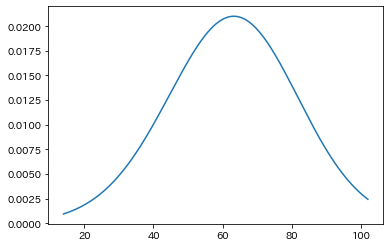

In [163]:
# 混合正規分布の数
k_size = 3

# 正規分布の割合
lambda_vec=[0.2, 0.2, 0.6]

# 平均(mu)の初期値
mu_vec=[mu0_first, mu1_first, mu2_first]
# 分散(sigma)の初期値
sigma2_vec=[sigma0_first, sigma1_first, sigma2_first]

# データ(-6から6までを200こ)
x = sp.linspace(np.min(random_x), np.max(random_x), 10000)
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, mu_vec, sigma2_vec), label="ini")


i: 0 lambda [0.2069 0.2036 0.5895] mu [67.6073 66.9097 61.2649] sigma2 [193.6303 231.3696 396.6413]
i: 30 lambda [0.4385 0.3738 0.1877] mu [68.5465 73.5421 32.9155] sigma2 [ 67.8724 116.2689 171.269 ]
i: 60 lambda [0.4334 0.4132 0.1534] mu [64.6327 76.293  27.3102] sigma2 [49.0049 85.4697 27.2909]
i: 90 lambda [0.2961 0.5503 0.1535] mu [61.355  75.1563 27.3288] sigma2 [21.3961 76.695  27.6178]
i: 120 lambda [0.1726 0.674  0.1534] mu [60.2724 72.8967 27.3131] sigma2 [ 8.1606 92.04   27.3685]
i: 150 lambda [0.154  0.6927 0.1533] mu [60.0421 72.6072 27.3106] sigma2 [ 6.5424 93.0859 27.3343]
i: 180 lambda [0.1501 0.6965 0.1533] mu [59.9883 72.5488 27.3102] sigma2 [ 6.2084 93.2677 27.3283]
i: 210 lambda [0.1489 0.6978 0.1533] mu [59.9708 72.5305 27.31  ] sigma2 [ 6.1026 93.3218 27.3265]
i: 240 lambda [0.1485 0.6982 0.1533] mu [59.9643 72.5239 27.31  ] sigma2 [ 6.0637 93.3413 27.3259]
i: 270 lambda [0.1483 0.6984 0.1533] mu [59.9618 72.5213 27.3099] sigma2 [ 6.0487 93.3487 27.3256]
i: 300 la

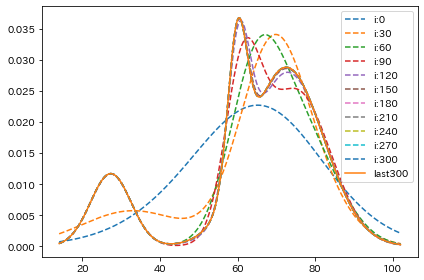

In [164]:
# 100回繰り返す
for i in sp.arange(300+1):
    # Estep
    # responsibilityの更新 
    responsibility = EStep(k_size, data_x, lambda_vec, mu_vec, sigma2_vec)
    
    # Mstep
    # 混合割合, 平均, 分散の更新
    lambda_vec, mu_vec, sigma2_vec = MStep(k_size, responsibility, data_x)
    
    if i % 30 == 0:
        print("i:", i, "lambda", lambda_vec.round(4), "mu", mu_vec.round(4), "sigma2", sigma2_vec.round(4))
        plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, mu_vec, sigma2_vec), label=f"i:{i}", linestyle="--")
        
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, mu_vec, sigma2_vec), label=f"last{i}", linestyle="-")

plt.legend()
plt.tight_layout()
plt.show()

In [165]:
k_size

3

In [166]:
print("f0の混合比率", lambda_vec[0])
print("mu0", mu_vec[0])
print("sigma0", sigma2_vec[0])

f0の混合比率 0.14823632879435852
mu0 59.96074993697144
sigma0 6.042717244564692


In [167]:
print("f1の混合比率", lambda_vec[1])
print("mu1", mu_vec[1])
print("sigma1", sigma2_vec[1])

f1の混合比率 0.6984395510755678
mu1 72.52028092779774
sigma1 93.3516580282996


In [168]:
print("f2の混合比率", lambda_vec[2])
print("mu2", mu_vec[2])
print("sigma2", sigma2_vec[2])

f2の混合比率 0.15332412013007363
mu2 27.30994161659653
sigma2 27.325538005641377


# 真の値

- N1 = stats.norm(loc=30, scale=sp.sqrt(5))  
- N2 = stats.norm(loc=60, scale=sp.sqrt(2.5))  
- N3 = stats.norm(loc=72, scale=sp.sqrt(10))  

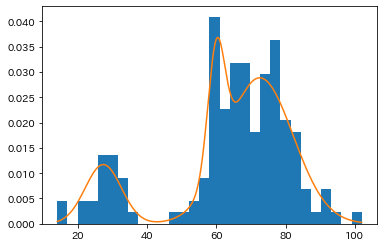

In [169]:
# 推定された分布の可視化
plt.hist(data_x, bins=30, density=True)
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, mu_vec, sigma2_vec), label=f"last{i}", linestyle="-")

# ✅実データでシミュレーション

In [6]:
import pandas as pd

# 乱数seedの固定
np.random.seed(seed=123)

df = pd.read_excel("../../data/data_covid_fix_name.xlsx")
df = df.dropna().reset_index(drop=True)

In [7]:
df.head()

,country,pop,urb,gdp,dist,hf,pf,ef,date_first,detection,status,cumul,air
0,Albania,2866376,60.319,13364.155397,6.996524e+06,7.84,8.005411,7.67,70,74.3,1,108641,303.14
1,Algeria,42228429,72.629,15481.787620,9.108277e+06,4.99,5.201489,4.77,58,12.0,1,80272,6442.44
2,Angola,30809762,65.514,6452.355165,1.049012e+07,5.40,5.979936,4.83,83,17.9,1,303691,76.94
3,Argentina,44494502,91.870,20610.568550,1.902562e+07,6.86,8.044600,5.67,65,74.9,1,92122,1516.63
4,Australia,24992369,86.012,51663.365095,7.608913e+06,8.62,9.160533,8.07,26,97.3,1,1347,75667.65


In [172]:
y = df["date_first"]

Text(0.5, 1.0, '初感染が起きるまでの日数')

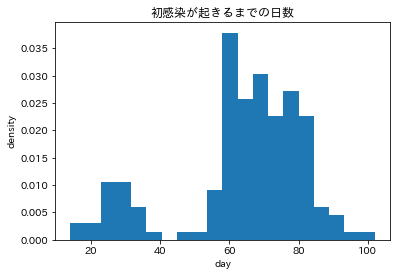

In [173]:
plt.hist(y, bins=20, density=True)
plt.xlabel("day")
plt.ylabel("density")
plt.title("初感染が起きるまでの日数")

## 初期値の設定

In [190]:
"""mu0_first = 30
sigma0_first = 5
print("mu0の初期値", mu0_first)
print("sigma0の初期値", sigma0_first)


mu1_first = 60
sigma1_first = 5
print("mu1の初期値", mu1_first)
print("sigma1の初期値", sigma1_first)

mu2_first = 70
sigma2_first = 20
#sigma2_first = np.var(random_x2)
print("mu2の初期値", mu2_first)
print("sigma2の初期値", sigma2_first)"""


# 初期値は主観なし
# データをランダムに3分割
random_x = np.split(y, 3)
random_x0 = random_x[0]
random_x1 = random_x[1]
random_x2 = random_x[2]

mu0_first = np.mean(random_x0)
sigma0_first = np.sum((random_x0 - np.mean(data_x))**2)/random_x0.shape[0]
#sigma1_first = np.var(random_x1)
print("mu0の初期値", mu0_first)
print("sigma0の初期値", sigma0_first)

mu1_first = np.mean(random_x1)
sigma1_first = np.sum((random_x1 - np.mean(data_x))**2)/random_x1.shape[0]
#sigma1_first = np.var(random_x1)
print("mu1の初期値", mu1_first)
print("sigma1の初期値", sigma1_first)

mu2_first = np.mean(random_x2)
sigma2_first = np.sum((random_x2 - np.mean(data_x))**2)/random_x2.shape[0]
#sigma2_first = np.var(random_x2)
print("mu2の初期値", mu2_first)
print("sigma2の初期値", sigma2_first)

mu0の初期値 65.24
sigma0の初期値 266.11257777777774
mu1の初期値 65.04
sigma1の初期値 301.48324444444444
mu2の初期値 60.9
sigma2の初期値 421.60004444444445


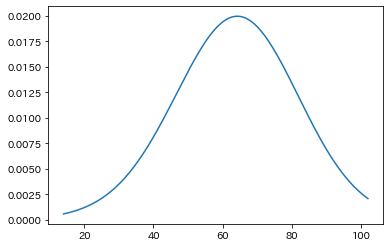

In [191]:
# 混合正規分布の数
k_size = 3

# 正規分布の割合
lambda_vec=[0.3, 0.3, 0.3]

# 平均(mu)の初期値
mu_vec=[mu0_first, mu1_first, mu2_first]
# 分散(sigma)の初期値
sigma2_vec=[sigma0_first, sigma1_first, sigma2_first]

# データ(-6から6までを200こ)
x = sp.linspace(np.min(y), np.max(y), 200)
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, mu_vec, sigma2_vec), label="ini")

i: 0 lambda [0.3342 0.3314 0.3345] mu [66.7081 65.7379 58.7552] sigma2 [225.1605 271.2377 454.5625]
i: 50 lambda [0.4356 0.411  0.1534] mu [64.4101 76.5913 27.3108] sigma2 [47.0839 81.3092 27.2986]
i: 100 lambda [0.1916 0.655  0.1534] mu [60.4912 73.1993 27.316 ] sigma2 [ 9.8953 90.813  27.4124]
i: 150 lambda [0.152  0.6946 0.1533] mu [60.015  72.5772 27.3104] sigma2 [ 6.3721 93.1807 27.3312]
i: 200 lambda [0.1489 0.6978 0.1533] mu [59.9705 72.5303 27.31  ] sigma2 [ 6.101  93.3226 27.3265]
i: 250 lambda [0.1483 0.6983 0.1533] mu [59.9623 72.5219 27.31  ] sigma2 [ 6.0519 93.3471 27.3257]
i: 300 lambda [0.1482 0.6985 0.1533] mu [59.9606 72.5201 27.3099] sigma2 [ 6.0416 93.3522 27.3255]
i: 350 lambda [0.1482 0.6985 0.1533] mu [59.9602 72.5197 27.3099] sigma2 [ 6.0394 93.3533 27.3255]
i: 400 lambda [0.1482 0.6985 0.1533] mu [59.9601 72.5196 27.3099] sigma2 [ 6.0389 93.3535 27.3255]


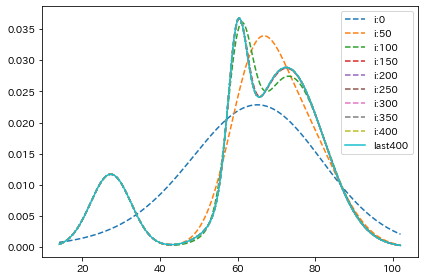

In [192]:
# 400回繰り返す
for i in sp.arange(400+1):
    # Estep
    # responsibilityの更新 
    responsibility = EStep(k_size, y, lambda_vec, mu_vec, sigma2_vec)
    
    # Mstep
    # 混合割合, 平均, 分散の更新
    lambda_vec, mu_vec, sigma2_vec = MStep(k_size, responsibility, y)
    
    if i % 50 == 0:
        print("i:", i, "lambda", lambda_vec.round(4), "mu", mu_vec.round(4), "sigma2", sigma2_vec.round(4))
        plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, mu_vec, sigma2_vec), label=f"i:{i}", linestyle="--")
        
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, mu_vec, sigma2_vec), label=f"last{i}", linestyle="-")

plt.legend()
plt.tight_layout()
plt.show()

## 推定結果

In [193]:
print("f1の混合比率", lambda_vec[0])
print("mu1", mu_vec[0])
print("sigma1", sigma2_vec[0])

f1の混合比率 0.14819254011815838
mu1 59.960104899160704
sigma1 6.038887996109623


In [194]:
print("f1の混合比率", lambda_vec[1])
print("mu1", mu_vec[1])
print("sigma1", sigma2_vec[1])

f1の混合比率 0.6984834041805134
mu1 72.51962731494268
sigma1 93.35354696275746


In [195]:
print("f2の混合比率", lambda_vec[2])
print("mu2", mu_vec[2])
print("sigma2", sigma2_vec[2])

f2の混合比率 0.1533240557013282
mu2 27.309936721359676
sigma2 27.32547489769405


Text(0.5, 1.0, '初感染が起きるまでの日数')

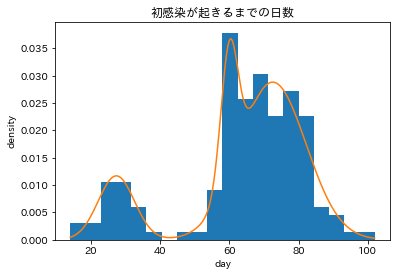

In [196]:
# 推定された分布の可視化
plt.hist(y, bins=20, density=True)
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, mu_vec, sigma2_vec), label=f"last{i}", linestyle="-")
plt.xlabel("day")
plt.ylabel("density")
plt.title("初感染が起きるまでの日数")

In [197]:
pd.DataFrame([lambda_vec, mu_vec, sigma2_vec], columns=["comp1", "comp2", "comp3"], index=["混合比", "mu", "sigma"])

,comp1,comp2,comp3
混合比,0.148193,0.698483,0.153324
mu,59.960105,72.519627,27.309937
sigma,6.038888,93.353547,27.325475


# G成分混合を仮定

Text(0.5, 1.0, '初感染が起きるまでの日数')

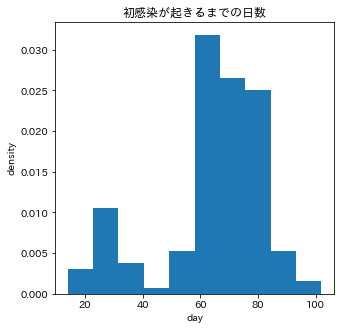

In [8]:
import pandas as pd

# 乱数seedの固定
np.random.seed(seed=123)

df = pd.read_excel("../../data/data_covid_fix_name.xlsx")
df = df.dropna().reset_index(drop=True)

y = df["date_first"]
plt.figure(figsize=(5,5))
plt.hist(y, density=True)
plt.xlabel("day")
plt.ylabel("density")
plt.title("初感染が起きるまでの日数")

In [14]:
k_size=7
random_x = np.array_split(y, k_size)

mu_vec=np.zeros(k_size)
sigma2_vec=np.zeros(k_size)
for i in range(k_size):
    mu_vec[i] = np.mean(random_x[i])
    sigma2_vec[i] = np.sum((random_x[i] - np.mean(y))**2)/random_x[i].shape[0]
    
lambda_vec = np.ones(k_size)/k_size
    
first_df = pd.DataFrame([lambda_vec, mu_vec, sigma2_vec], columns=[f"comp{i}_(初期値)" for i in range(k_size)], index=["混合比", "mu", "sigma"])
first_df

,comp0_(初期値),comp1_(初期値),comp2_(初期値),comp3_(初期値),comp4_(初期値),comp5_(初期値),comp6_(初期値)
混合比,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
mu,66.045455,65.590909,62.045455,64.952381,67.523810,58.666667,61.142857
sigma,216.783802,239.898954,315.597135,394.690584,188.001060,372.873441,590.608044


i: 0 lambda [0.1451 0.1429 0.1394 0.1391 0.1505 0.1415 0.1416] mu [68.2682 67.5506 62.5213 63.6312 69.5753 57.3973 56.5974] sigma2 [159.9039 191.4878 336.9601 373.3016 120.6547 440.8296 540.1803]
i: 100 lambda [0.2413 0.2609 0.0586 0.0529 0.233  0.0132 0.1401] mu [61.1284 75.7876 82.863  82.0439 67.8992 14.9922 28.4604] sigma2 [ 12.4523  24.3532 103.4306 108.0841  78.1977   0.9999  13.9997]
i: 200 lambda [0.1436 0.251  0.034  0.023  0.3951 0.0132 0.1401] mu [60.1972 77.9739 94.4488 77.4348 66.6487 14.9922 28.463 ] sigma2 [ 7.2938 19.4971 17.9753 81.8815 53.6076  0.9999 14.0137]
i: 300 lambda [0.0683 0.2828 0.037  0.0164 0.4421 0.0132 0.1401] mu [59.003  78.1431 94.1821 70.998  65.0429 14.9922 28.4632] sigma2 [  0.7451  18.2078  19.0208 102.0152  41.3653   0.9999  14.0148]
i: 400 lambda [0.0686 0.326  0.0375 0.0328 0.3819 0.0132 0.1401] mu [58.9748 77.7295 94.1648 58.0934 64.7381 14.9922 28.46  ] sigma2 [ 0.7547 19.7061 19.0537 52.749  30.4482  0.9999 13.9976]
i: 500 lambda [0.071  0.36

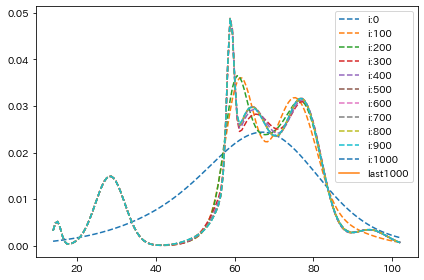

In [15]:
# 1000回繰り返す
x = sp.linspace(np.min(y), np.max(y), len(y))

for i in sp.arange(1000+1):
    # Estep
    # responsibilityの更新 
    responsibility = EStep(k_size, y, lambda_vec, mu_vec, sigma2_vec)
    
    # Mstep
    # 混合割合, 平均, 分散の更新
    lambda_vec, mu_vec, sigma2_vec = MStep(k_size, responsibility, y)
    
    if i % 100 == 0:
        print("i:", i, "lambda", lambda_vec.round(4), "mu", mu_vec.round(4), "sigma2", sigma2_vec.round(4))
        plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, mu_vec, sigma2_vec), label=f"i:{i}", linestyle="--")
        
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, mu_vec, sigma2_vec), label=f"last{i}", linestyle="-")

plt.legend()
plt.tight_layout()
plt.show()

In [16]:
res_df = pd.DataFrame([lambda_vec, mu_vec, sigma2_vec], columns=[f"comp{i}" for i in range(k_size)], index=["混合比", "mu", "sigma"])
res_df

,comp0,comp1,comp2,comp3,comp4,comp5,comp6
混合比,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mu,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sigma,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, '初感染が起きるまでの日数')

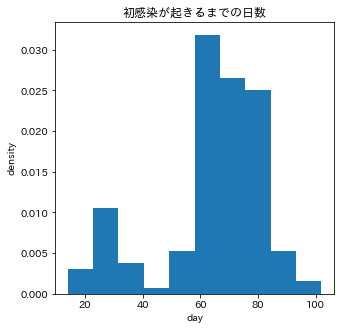

In [17]:
# 推定された分布の可視化
plt.figure(figsize=(5,5))
plt.hist(y, density=True)
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, mu_vec, sigma2_vec), label=f"last{i}", linestyle="-")
plt.xlabel("day")
plt.ylabel("density")
plt.title("初感染が起きるまでの日数")

In [18]:
# 対数尤度を計算
likelihood=0
for i in range(k_size):
    _norm = stats.norm(loc=mu_vec[i], scale=np.sqrt(sigma2_vec[i])).pdf(y)
    _norm = lambda_vec[i] * _norm
    likelihood+=_norm
likelihood = np.sum(np.log(likelihood))
likelihood

nan

In [19]:
likelihood

nan